In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

### Generate Step Data

In [31]:
# Heater steps
Qd = np.zeros(601)
Qd[10:200] = 80
Qd[200:400] = 20
Qd[400:] = 50

In [32]:
# read data file
data = pd.read_csv("https://apmonitor.com/do/uploads/Main/tclab_dyn_data1.txt")

In [33]:
print(data.columns)

Index(['Time', 'H1', 'T1'], dtype='object')


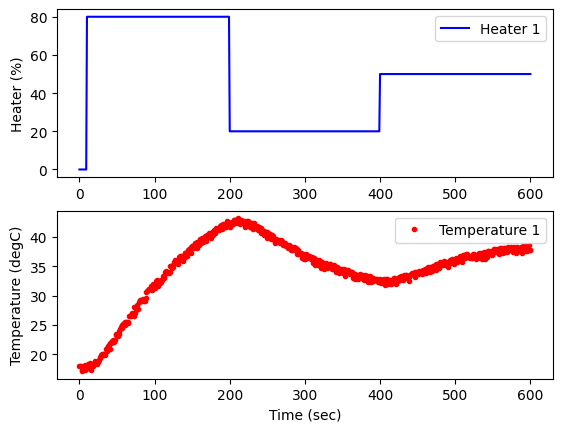

In [34]:
# Plot measurements
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(data['Time'], data['H1'], 'b-', label='Heater 1')
plt.ylabel('Heater (%)')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(data['Time'], data['T1'], 'r.', label='Temperature 1')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')

plt.show()

### GEKKO Energy Balance

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [36]:
# Initialize GEKKO model
m = GEKKO(remote=False)

In [37]:
# Model Discretized Time
n = 60 * 10 + 1  # Number of second time points (10 mins)
m.time = np.linspace(0, n-1, n)  # Time vvector

In [38]:
Q = m.Param(value=Qd)  # Percent Heater (0-100%)

In [39]:
T0 = m.Param(value=17.0 + 273.15)   # Initial temperature
Ta = m.Param(value=17.0 + 273.15)   # K
U =  m.Param(value=10.0)            # W/m^2-K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K
A = m.Param(value=12.0/100.0**2)    # Area im m^2
alpha = m.Param(value=0.01)         # W/ % heater
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzman

In [40]:
T = m.Var(value=T0)         # Temperature state as GEKKO variable

In [41]:
m.Equation(T.dt() == (1.0/(mass*Cp)) * (U * A * (Ta - T) + eps * sigma * A * (Ta**4 - T**4) + alpha * Q))

# simulation mode
m.options.IMODE = 4

# simulation model
m.solve()

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  1
   Variables    :  10
   Intermediates:  0
   Connections  :  0
   Equations    :  1
   Residuals    :  1
 
 Number of state variables:    1200
 Number of total equations: -  1200
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
     

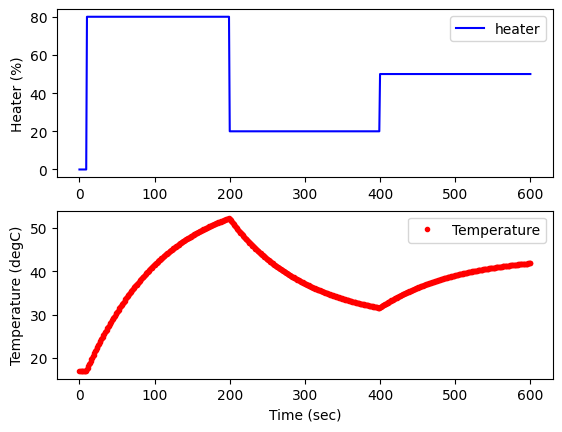

In [42]:
# Plot results
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(m.time, Q.value, 'b-', label='heater')
plt.ylabel('Heater (%)')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(m.time, np.array(T.value)-273.15, 'r.', label='Temperature')
plt.legend(loc='best')
plt.ylabel('Temperature (degC)')
plt.xlabel('Time (sec)')
plt.show()

In [43]:
from gekko import GEKKO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# Load data and parse into columns
url = 'http://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
data = pd.read_csv(url)
t = data['Time']
u = data['H1']
y = data['T1']

In [45]:
m = GEKKO()

# System identification
na = 2 # output coefficients
nb = 2 # input coefficients
yp, p, K = m.sysid(t, u, y, na, nb, pred='meas')


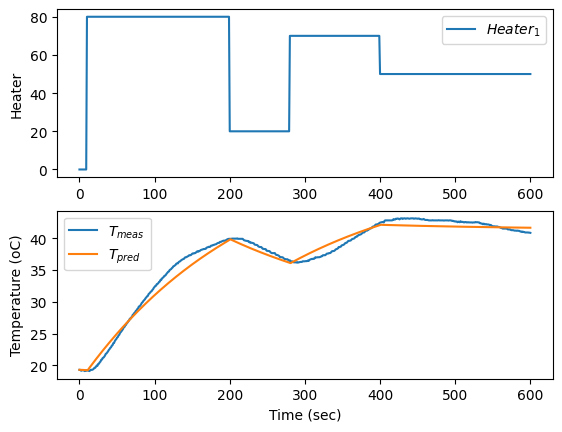

In [46]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, u, label=r'$Heater_1$')
plt.legend()
plt.ylabel('Heater')
plt.subplot(2, 1, 2)
plt.plot(t, y)
plt.plot(t, yp)
plt.legend([r'$T_{meas}$', r'$T_{pred}$'])
plt.ylabel('Temperature (oC)')
plt.xlabel('Time (sec)')
plt.show()


### GEKKO with neural network

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from gekko import GEKKO
import time

In [48]:
url = 'https://apmonitor.com/do/uploads/Main/tclab_ss_data1.txt'
data = pd.read_csv(url)

In [49]:
# -------------------------------------
# scale data
# -------------------------------------
x = data['Heater'].values
y= data['Temperature'].values

# minimum of x, y
x_min = min(x)
y_min = min(y)

# range of x, y
x_range = max(x) - x_min
y_range = max(y) - y_min

# scaled data
xs = (x - x_min) / x_range
ys = (y - y_min) / y_range

In [50]:
# -------------------------------------
# build neural network
# -------------------------------------

In [51]:
nin = 1    # inputs
n1 = 1     # hidden layer 1 (linear)
n2 = 1     # hidden layer 2 (non-linear)
n3 = 1     # hidden layer 3 (linear)
nout = 1   # outputs

# Initialize gekko models
train = GEKKO(remote=False)
test = GEKKO(remote=False)
dyn = GEKKO(remote=False)
model = [train, test, dyn]


In [52]:
for m in model:
    # input(s)
    m.inpt = m.Param()

    # Layer 1
    m.w1 = m.Array(m.FV, (nin, n1))
    m.l1 = [m.Intermediate(m.w1[0, i] * m.inpt) for i in range(n1)]

    # Layer 2
    m.w2 = m.Array(m.FV, (n1, n2))
    m.l2 = [m.Intermediate(sum([m.tanh(m.w2[j, i] * m.l1[j]) \
                               for j in range(n1)])) for i in range(n2)]

    # Layer 3
    m.w3 = m.Array(m.FV, (n2, n3))
    m.l3 = [m.Intermediate(sum([m.w3[j, i] * m.l2[j] \
                                for j in range(n2)])) for i in range(n3)]

    # Output(s)
    m.outpt = m.CV()
    m.Equation(m.outpt==sum([m.l3[i] for i in range(n3)]))

    # flatten matrices
    m.w1 = m.w1.flatten()
    m.w2 = m.w2.flatten()
    m.w3 = m.w3.flatten()

In [53]:
# -------------------------------------
# fit parameter weights
# -------------------------------------
m = train
m.inpt.value = xs
m.outpt.value = ys
for i in range(len(m.w1)):
    m.w1[i].FSTATUS = 1
    m.w1[i].STATUS = 1
    m.w1[i].MEAS = 1.0
for i in range(len(m.w2)):
    m.w2[i].FSTATUS = 1
    m.w2[i].STATUS = 1
    m.w2[i].MEAS = 0.5
for i in range(len(m.w3)):
    m.w3[i].FSTATUS = 1
    m.w3[i].STATUS = 1
    m.w3[i].MEAS = 1.0
m.options.IMODE = 2
m.options.SOLVER = 3
m.options.EV_TYPE = 2
m.solve(disp=False)

In [54]:
# -------------------------------------
# test sample points
# -------------------------------------
m = test
for i in range(len(m.w1)):
    m.w1[i].MEAS = train.w1[i].NEWVAL
    m.w1[i].FSTATUS = 1
    print(f'w1[{i}]: {m.w1[i].MEAS}')
for i in range(len(m.w2)):
    m.w2[i].MEAS = train.w2[i].NEWVAL
    m.w2[i].FSTATUS = 1
    print(f'w2[{i}]: {m.w1[i].MEAS}')
for i in range(len(m.w3)):
    m.w3[i].MEAS = train.w3[i].NEWVAL
    m.w3[i].FSTATUS = 1
    print(f'w3[{i}]: {m.w3[i].MEAS}')

m.inpt.value = np.linspace(-0.1, 1.5, 100)
m.options.IMODE = 2
m.options.SOLVER = 3
m.solve(disp=False)

w1[0]: 0.82866143467
w2[0]: 0.82866143467
w3[0]: 1.6296720879


In [55]:
# -------------------------------------
# un-scale predictions
# -------------------------------------
xp = np.array(test.inpt.value) * x_range + x_min
yp = np.array(test.outpt.value) * y_range + y_min

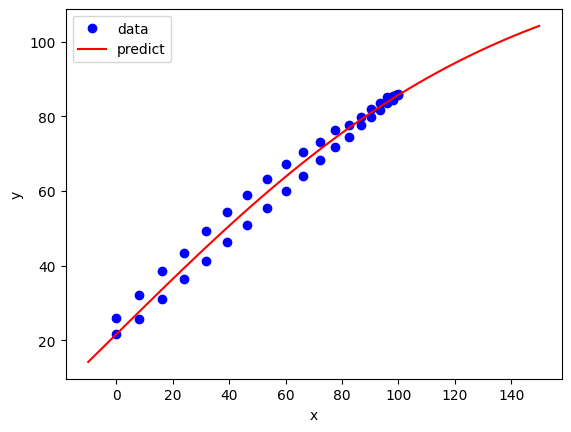

In [56]:
# -------------------------------------
# plot results
# -------------------------------------
plt.figure()
plt.plot(x, y, 'bo', label='data')
plt.plot(xp, yp, 'r-', label='predict')
plt.legend(loc='best')
plt.ylabel('y')
plt.xlabel('x')

plt.show()

In [57]:
# -------------------------------------
# generate dynamic predictions
# -------------------------------------
m = dyn
m.time = np.linspace(0, 600, 601)
# Load neural network parameters
for i in range(len(m.w1)):
    m.w1[i].MEAS = train.w1[i].NEWVAL
    m.w1[i].FSTATUS = 1
for i in range(len(m.w2)):
    m.w2[i].MEAS = train.w2[i].NEWVAL
    m.w2[i].FSTATUS = 1
for i in range(len(m.w3)):
    m.w3[i].MEAS = train.w3[i].NEWVAL
    m.w3[i].FSTATUS = 1

# double test
Qd = np.zeros(601)
Qd[10:200] = 80
Qd[200:400] = 20
Qd[400:] = 50
Q = m.Param()
Q.value = Qd
# scaled input
m.inpt.value = (Qd - x_min) / x_range

In [58]:
# define Temperature output
Q0 = 0  # initial heater
T0 = 23 # initial temperature
# scaled steady statee output
T_ss = m.Var(value=T0)
m.Equation(T_ss == m.outpt * y_range + y_min)
# dynamic prediction
T = m.Var(value=T0)
# time constant
tau = m.Param(value=120) # determine in a later exercise
# additional model equation for dynamics
m.Equation(tau * T.dt() == -(T-T0) + (T_ss - T0))

# solve dynamic simulation
m.options.IMODE = 4
m.solve()

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  9
   Intermediates:  3
   Connections  :  0
   Equations    :  6
   Residuals    :  3
 
 Number of state variables:    2400
 Number of total equations: -  2400
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
      

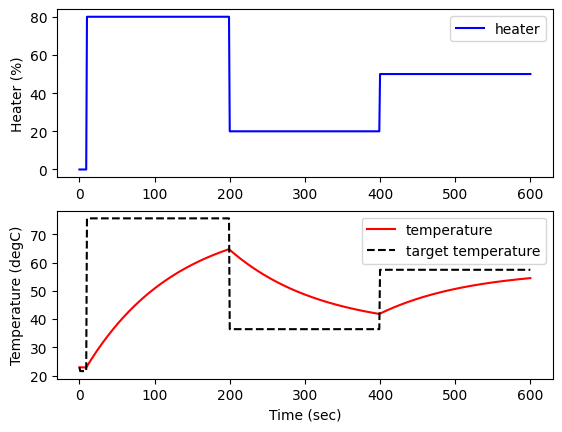

In [59]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time, Q.value, 'b-', label='heater')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(m.time, T.value, 'r-', label='temperature')
plt.plot(m.time, T_ss.value, 'k--', label='target temperature')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.show()